## Implementing LSTM to detect and classify Parkinsons' Freezing of Gait types in time series data

### What is LSTM?
- a type of neural network
- it is based on Recurrent Neural Networks (solves the problem of vanishing/exploding gradients)
    - instead of one feedback loop, the LSTM uses two paths to predict the next value (Long-Term Memory and Short-Term Memory)
- also a stepping stone to Transformers

=> for a detailed explanation, check out the [Quest](https://www.youtube.com/watch?v=YCzL96nL7j0&t=0)

### How does an LSTM unit look like?
![LSTM unit](./img/lstm_unit.png)

In [ ]:
using Pkg

# Pkg.add("CSV")
# Pkg.add("Flux")
# Pkg.add("BSON")
# Pkg.add("Plots")
# Pkg.add("NNlib")
# Pkg.add("DataFrames")
# Pkg.add("MLDataUtils")
# Pkg.add("Distributions")
# Pkg.add("ResumableFunctions")

In [1]:
using Flux

using CSV
using Plots
using NNlib
using Random
using DataFrames
using Distributions
using ResumableFunctions
using BSON: @save, @load

┌ Error: This version of CUDA.jl only supports NVIDIA drivers for CUDA 11.x or higher (yours is for CUDA 9.1.0)
└ @ CUDA C:\Users\hurub\.julia\packages\CUDA\pCcGc\src\initialization.jl:70


## Implementing moving average to smoothen the input data

In [2]:
# smoothing a vector's values by applying moving average
function moving_average(data; window_size = 100)
    ma = []

    for i = 1 : size(data, 1)
        if i < window_size
            append!(ma, [sum(data[1:i]) / i])
        else
            append!(ma, [sum(data[i-window_size+1:i]) / window_size])
        end
    end

    ma
end

moving_average (generic function with 1 method)

In [15]:
function smoothen(dataframe)
    window_size = 40

    df_copy = deepcopy(dataframe)

    df_copy[!, "AccV"]  = moving_average(dataframe[!, "AccV"], window_size=window_size)
    df_copy[!, "AccML"] = moving_average(dataframe[!, "AccML"], window_size=window_size)
    df_copy[!, "AccAP"] = moving_average(dataframe[!, "AccAP"], window_size=window_size)

    df_copy
end

smoothen (generic function with 1 method)

## Reading Train and Validation data

In [17]:
parkinson_train_raw = CSV.read("./train_data.csv", DataFrame)
parkinson_validation_raw = CSV.read("./validation_data.csv", DataFrame)

parkinson_train = smoothen(parkinson_train_raw)
parkinson_validation = smoothen(parkinson_train_raw)


Row,Id,Subject,Visit,Test,Medication,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,event
,String15,String7,Int64,Int64,String3,Int64,Any,Any,Any,Int64,Int64,Int64,String15
1,827fff250f,a03db7,3,1,off,7614,-7.46998,-1.10929,1.77215,0,0,0,Normal
2,550185d2ac,3b2b7a,4,3,on,1382,-8.83002,0.0635208,2.74853,0,0,0,Normal
3,867e5f1732,c8e721,4,2,off,2558,-8.89725,0.0608231,0.756788,0,0,0,Normal
4,83ce03ef33,220a17,2,2,off,1557,-9.07247,-0.131305,0.401756,0,0,0,Normal
5,e7b5afe544,2d57c2,13,2,off,32627,-8.91998,-0.252756,1.08382,0,1,0,Turn
6,64dec54859,8db7dd,4,2,on,1450,-9.17541,-0.246068,1.50453,0,0,0,Normal
7,71bc892dd5,220a17,2,3,off,9990,-9.14558,-0.434009,1.23073,0,0,0,Normal
8,8522292a1b,743f4e,13,2,on,4538,-9.2008,-0.293232,1.22548,0,0,0,Normal
9,d4c5161465,7eb666,4,1,off,2835,-8.98826,-0.101612,1.33484,0,0,0,Normal


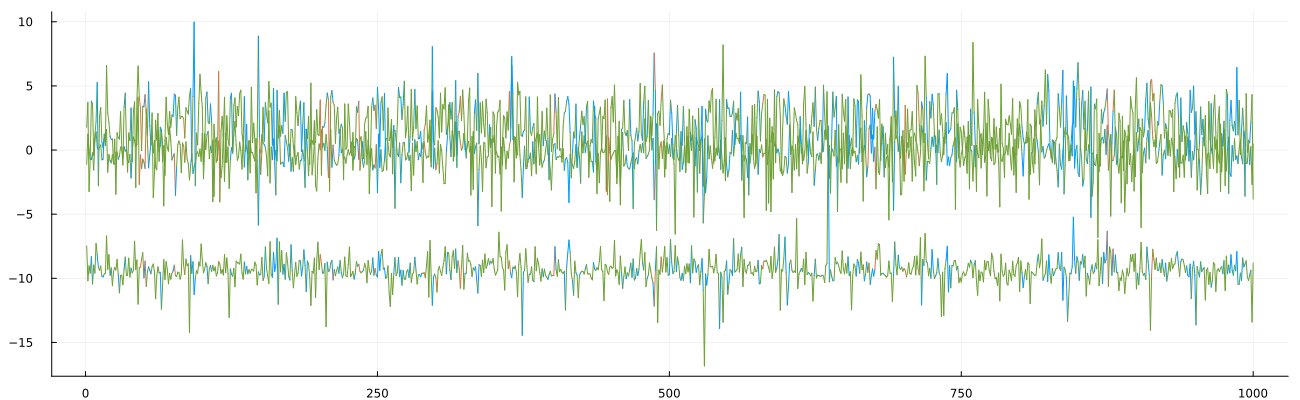

In [105]:
range = 1:1000

raw_plot = Plots.plot(
    collect(range), parkinson_train_raw[!, "AccV"][range],
    color=0*parkinson_train_raw[!, "StartHesitation"][range] + 1*parkinson_train_raw[!, "Turn"][range] + 2*parkinson_train_raw[!, "Walking"][range],
    label="Accv Raw"
)


Plots.plot!(raw_plot,
    collect(range), parkinson_train_raw[!, "AccML"][range],
    color=0*parkinson_train_raw[!, "StartHesitation"][range] + 1*parkinson_train_raw[!, "Turn"][range] + 2*parkinson_train_raw[!, "Walking"][range],
    label="AccML Raw"
)


Plots.plot!(raw_plot,
    collect(range), parkinson_train_raw[!, "AccAP"][range],
    color=0*parkinson_train_raw[!, "StartHesitation"][range] + 1*parkinson_train_raw[!, "Turn"][range] + 2*parkinson_train_raw[!, "Walking"][range],
    label="AccAP Raw"
)


plot!(size=(1300, 400), legend=false)

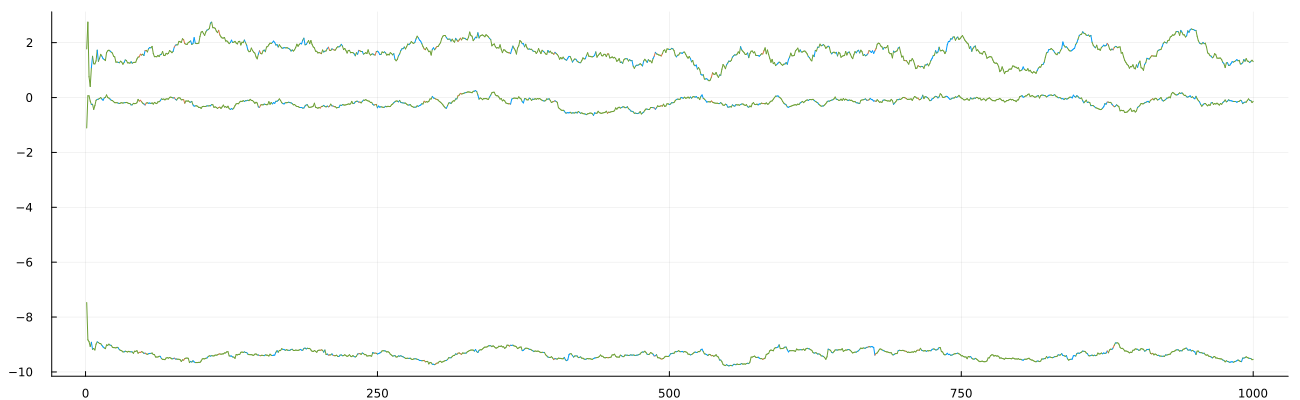

In [109]:
smooth_plot = Plots.plot(
    collect(range), parkinson_train[!, "AccV"][range],
    color=0*parkinson_train[!, "StartHesitation"][range] + 1*parkinson_train[!, "Turn"][range] + 2*parkinson_train[!, "Walking"][range],
    label="AccV Smooth",
)
Plots.plot!(smooth_plot,
    collect(range), parkinson_train[!, "AccML"][range],
    color=0*parkinson_train[!, "StartHesitation"][range] + 1*parkinson_train[!, "Turn"][range] + 2*parkinson_train[!, "Walking"][range],
    label="AccML Smooth"
)
Plots.plot!(smooth_plot,
    collect(range), parkinson_train[!, "AccAP"][range],
    color=0*parkinson_train[!, "StartHesitation"][range] + 1*parkinson_train[!, "Turn"][range] + 2*parkinson_train[!, "Walking"][range],
    label="AccAP Smooth"
)

plot!(size=(1300, 400), legend=false)

## Implementing data loader

In [37]:
@resumable function data_loader(dataframe, num_sequences, num_selected_sequences, batch_size; labels=["StartHesitation", "Turn", "Walking", "Normal"])
    @assert num_selected_sequences <= num_sequences
    
    df = deepcopy(dataframe)
    
    sequences = collect(1:num_sequences)
    shuffle!(sequences)

    # Sending to the model
    for i in 1:num_selected_sequences
        # if benne van a random generalt elemek tombunkben
        x = hcat(
            df[!, "AccV"][sequences[i] * batch_size : sequences[i] * batch_size + batch_size],
            df[!, "AccML"][sequences[i] * batch_size : sequences[i] * batch_size + batch_size],
            df[!, "AccAP"][sequences[i] * batch_size : sequences[i] * batch_size + batch_size]
        )
    
        y = Flux.onehotbatch(df[!, "event"][sequences[i] * batch_size : sequences[i] * batch_size + batch_size], labels)
        
        @yield x, y
    end
end

data_loader (generic function with 1 method)

## Implementing the LSTM model from scratch

### 0. Function to initialize model weights (Gaussian distribution on the (-1, 1) interval)

In [38]:
function init_params(in::Integer, out::Integer; mean=0.0, std=1.0)
    [
        in, out,
        
        rand(Truncated(Normal(mean, std), -1, 1), out), # wlr1
        rand(Truncated(Normal(mean, std), -1, 1), out), # wlr2
        rand(Truncated(Normal(mean, std), -1, 1), out), # blr1

        rand(Truncated(Normal(mean, std), -1, 1), out), # wpr1
        rand(Truncated(Normal(mean, std), -1, 1), out), # wpr2
        rand(Truncated(Normal(mean, std), -1, 1), out), # bpr1
        
        rand(Truncated(Normal(mean, std), -1, 1), out), # wp1
        rand(Truncated(Normal(mean, std), -1, 1), out), # wp2
        rand(Truncated(Normal(mean, std), -1, 1), out), # bp1
        
        rand(Truncated(Normal(mean, std), -1, 1), out), # wo1
        rand(Truncated(Normal(mean, std), -1, 1), out), # wo2
        rand(Truncated(Normal(mean, std), -1, 1), out), # bo1

        # both the Long-Term and Short-Term memories are initialized with 0 values
        zeros(out),  # c
        zeros(out),  # h
        true # update_memory
    ]
end


init_params (generic function with 1 method)

### 1. Forward method which does the LSTM math and passes down the processed data for the next layer in the chain

In [39]:
# implementing the forwarding method which is used in the Chaining process
function forward(x, lstm)

    for i in 1:size(x, 1)
        long_remember_percent = NNlib.sigmoid_fast((lstm.c .* lstm.wlr1) + (x[i, :] .* lstm.wlr2) + lstm.blr1)
        potential_remember_percent = NNlib.sigmoid_fast((lstm.h .* lstm.wpr1) + (x[i, :] .* lstm.wpr2) + lstm.bpr1)
        potential_memory = NNlib.tanh_fast((lstm.c .* lstm.wp1) + (x[i, :] .* lstm.wp2) + lstm.bp1)
        updated_long_memory = (lstm.c .* long_remember_percent) + (potential_memory .* potential_remember_percent)
        output_percent = NNlib.sigmoid_fast((lstm.h .* lstm.wo1) + (x[i, :] .* lstm.wo2) + lstm.bo1)
        updated_short_memory = NNlib.tanh_fast(updated_long_memory) .* output_percent

        # updating the memory
        if lstm.update_memory
            lstm.c, lstm.h = updated_long_memory, updated_short_memory
        end
    end

    lstm.c
end

forward (generic function with 1 method)

### 2. Data Model of the LSTM layer

In [40]:
# custom Long Short-Term Memory layer
mutable struct LSTM
    # input and output size of the layer
    in::Integer
    out::Integer

    # Parameters of the Forget Gate
    #   > determines what percentage of the Long-Term Memory will be remembered
    wlr1::Vector{Float32}
    wlr2::Vector{Float32}
    blr1::Vector{Float32}

    # Parameters of the Input Gate
    #   > determines what percentage of the Potential Long-Term Memory will be remembered
    wpr1::Vector{Float32}
    wpr2::Vector{Float32}
    bpr1::Vector{Float32}

    #   > determines the Potential Long-Term Memory (it is added to the actual Long-Term Memory)
    wp1::Vector{Float32}
    wp2::Vector{Float32}
    bp1::Vector{Float32}

    # Parameters of the Output Gate
    #   > determines what percentage of the Short-Term Memory will be remembered
    wo1::Vector{Float32}
    wo2::Vector{Float32}
    bo1::Vector{Float32}

    # cell state (aka. long-term memory) and hidden state (aka. short-term memory)
    c::Vector{Float32}
    h::Vector{Float32}

    # prevents the model from modifying the memory state in case of testing and loss calculation
    # it needs to be set explicitely before and after calling the model(x) funtion
    update_memory::Bool
end

### 3. Settings that enables the custom layer to be used in chain like any other layers like Dense, Batchnorm, Dropout, etc.
#### 3.1 Defining the constructor

In [41]:
LSTM(in::Integer, out::Integer) = LSTM(init_params(in, out)...)

LSTM

#### 3.2 Overloading the `call` method, so the object can be used as a function

In [42]:
(lstm::LSTM)(x) = forward(x, lstm)

#### 3.3 Creating a functor from the struct, so that the training can optimize its parameters

In [43]:
Flux.@functor LSTM

#### 3.4 Creating the final Long Short-Term Memory layer

In [44]:
function LSTM((in, out)::Pair)
    LSTM(in, out) # constructor
end

LSTM

#### 3.5 Explicitely defining the trainable parameters of the layer

In [45]:
# all the Weights and Biases are trainable
#   exceptions >> Cell State and Hidden State
Flux.trainable(lstm::LSTM) = (lstm.wlr1, lstm.wlr2, lstm.blr1, lstm.wpr1, lstm.wpr2, lstm.bpr1, lstm.wp1, lstm.wp2, lstm.bp1, lstm.wo1, lstm.wo2, lstm.bo1)

### 4. Initial settings for training

In [88]:
# Random generating sequences
num_sequences = 10_000
num_selected_sequences = 1_000
batch_size_train = div(size(parkinson_train, 1), num_sequences)
batch_size_validation = div(size(parkinson_validation, 1), num_sequences)

epochs = 20

input_size = batch_size_train
hidden_size = 3
num_classes = 4 

;

### 5. Creating the model

In [89]:
# model = Chain(
#     LSTM(input_size => hidden_size),
#     Dense(hidden_size => 300),
#     Dense(300 => num_classes),
#     softmax
# )

model = Chain(
    LSTM(input_size => hidden_size),
    Dense(hidden_size => num_classes),
    softmax
)

;

### 6. Loss function & training

In [49]:
function loss(model, x, y)
    # preventing the model from updating its memory state when predicting
    model[1].update_memory = false
    l = Flux.crossentropy.(eachrow(model(x)'), eachrow(y'))
    model[1].update_memory = true

    mean(l)
end

optimizer = ADAM(0.001)

;

In [90]:
train_losses = []
validation_losses = []

for epoch in 1:epochs

  epoch_loss = 0f0

  for (x, y) in data_loader(parkinson_train, num_sequences, num_selected_sequences, batch_size_train)
    grads = Flux.gradient(Flux.params(model)) do
      l = loss(model, x, y) 
      epoch_loss += l

      l
    end
    Flux.update!(optimizer, Flux.params(model), grads)
  end

  train_loss = epoch_loss / num_selected_sequences 
  @info "Epoch: $epoch >> Loss: $train_loss"
  append!(train_losses, train_loss)

  
  # Validation of the epoch
  epoch_loss = 0f0

  for (x, y) in data_loader(parkinson_validation, num_sequences, num_selected_sequences, batch_size_validation)
      l = loss(model, x, y) 
      epoch_loss += l

      l
  end

  validation_loss = epoch_loss / num_selected_sequences 
  @info "Validation >> Loss: $validation_loss"
  append!(validation_losses, train_loss)

end

@save "LSTM.bson" model

[ Info: Epoch: 1 >> Loss: 1.09957
[ Info: Validation >> Loss: 0.92695695
[ Info: Epoch: 2 >> Loss: 0.8774139
[ Info: Validation >> Loss: 0.8555961
[ Info: Epoch: 3 >> Loss: 0.8350773
[ Info: Validation >> Loss: 0.8363362
[ Info: Epoch: 4 >> Loss: 0.8380812
[ Info: Validation >> Loss: 0.83657247
[ Info: Epoch: 5 >> Loss: 0.8402451
[ Info: Validation >> Loss: 0.830591
[ Info: Epoch: 6 >> Loss: 0.831815
[ Info: Validation >> Loss: 0.8350374
[ Info: Epoch: 7 >> Loss: 0.84060234
[ Info: Validation >> Loss: 0.82767624
[ Info: Epoch: 8 >> Loss: 0.83402115
[ Info: Validation >> Loss: 0.8403812
[ Info: Epoch: 9 >> Loss: 0.83795375
[ Info: Validation >> Loss: 0.8470918
[ Info: Epoch: 10 >> Loss: 0.83466893
[ Info: Validation >> Loss: 0.83657146
[ Info: Epoch: 11 >> Loss: 0.8403406
[ Info: Validation >> Loss: 0.8374467
[ Info: Epoch: 12 >> Loss: 0.83387166
[ Info: Validation >> Loss: 0.8295345
[ Info: Epoch: 13 >> Loss: 0.8348242
[ Info: Validation >> Loss: 0.8401508
[ Info: Epoch: 14 >> Loss: 0.

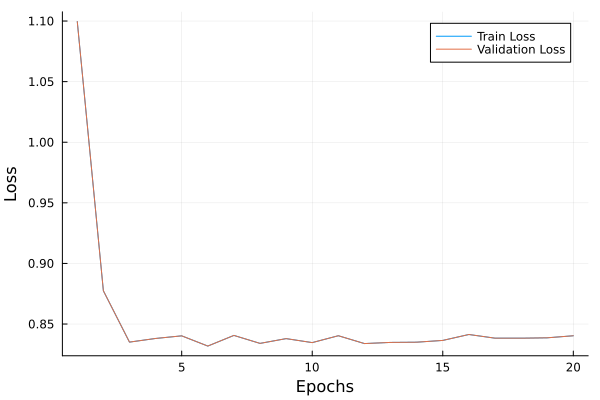

In [94]:
p = plot()
Plots.plot!(collect(1:epochs), train_losses, labels="Train Loss")
Plots.plot!(collect(1:epochs), validation_losses, labels="Validation Loss")
xaxis!("Epochs")
yaxis!("Loss")

## Testing the trained Model

In [83]:
function accuracy(model, data ; labels=["StartHesitation", "Turn", "Walking", "Normal"])
    model[1].update_memory = false
    accuracy = 0f0

    for i in 1:size(data, 1)
        x = hcat(
            data[!, "AccV"][i],
            data[!, "AccML"][i],
            data[!, "AccAP"][i]
        )
        
        accuracy += Flux.onecold(model(x), labels) == data[!, "event"][i]
    end

    model[1].update_memory = true

    accuracy / size(data, 1)
end

accuracy (generic function with 1 method)

In [57]:
parkinson_test_raw = CSV.read("./test_data.csv", DataFrame)
parkinson_test = smoothen(parkinson_test)

Row,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,event
,Int64,Any,Any,Any,Int64,Int64,Int64,String7
1,0,-9.53394,0.566322,-1.41353,0,0,0,Normal
2,1,-9.53504,0.565229,-1.42707,0,0,0,Normal
3,2,-9.53314,0.564074,-1.42783,0,0,0,Normal
4,3,-9.53267,0.564113,-1.42474,0,0,0,Normal
5,4,-9.5343,0.563661,-1.42569,0,0,0,Normal
6,5,-9.53468,0.561813,-1.42373,0,0,0,Normal
7,6,-9.53395,0.559848,-1.42231,0,0,0,Normal
8,7,-9.53276,0.558963,-1.42148,0,0,0,Normal
9,8,-9.5331,0.558296,-1.42133,0,0,0,Normal


In [54]:
@load "LSTM.bson" model

In [92]:
accuracy(model, parkinson_test)

0.83169585f0